In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, io, filters, util, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_ubyte

import os

## Задача 1 - подготовка массивов с изображениями

есть по 25 000 изображений котиков-песиков. Делаем 2200х2 трейн и 300х2 тест
картинки выравниваем, загружаем в массивы и сохраняем в h5 файлы

In [3]:
base_dir = '/home/sda/STUDY/mini-projects/TF-tf.data-cat-dog/data/images'

try:
    os.mkdir(os.path.join(base_dir, '0_ok'))
    os.mkdir(os.path.join(base_dir, '1_ok'))
except:
    pass

In [4]:
# 1. нужно прочистить картинки, удалить битые, удалить слишком мелкие, если все ок - 
# вернуть ресайз
resize_box = 128

def prepare_image(src_file, dst_file, min_pix = 128, resize_box = 128):
    try:
        image = io.imread(os.path.join(base_dir, src_file))
        
        # проверка минимальной пиксельности по осям
        if min(image.shape[:2]) < min_pix:
            return False
        
        # правильности цвета
        if image.shape[2] != 3:
            return False
        
        
        # ресайз - на выходе хотим получать квадратики resize_box на resize_box
        image_resized = resize(image, 
                              (int((image.shape[0] * resize_box) / min(image.shape[:2])), 
                               int((image.shape[1] * resize_box) / min(image.shape[:2]))))
        
        # теперь нужно сделать центрированный срез
        if image_resized.shape[0] != resize_box:
            x_min = (image_resized.shape[0] - resize_box) // 2
            x_max = x_min + resize_box 
        else:
            x_min = 0
            x_max = resize_box + 1
        
        if image_resized.shape[1] != resize_box:
            y_min = (image_resized.shape[1] - resize_box) // 2
            y_max = y_min + resize_box 
        else:
            y_min = 0
            y_max = resize_box + 1
        
        image_cropped = image_resized[x_min:x_max,y_min:y_max, :]
        
        if image_cropped.shape != (resize_box,resize_box,3):
            print(image.shape, image_resized.shape, image_cropped.shape, 
                  src_file, (x_min, x_max, y_min, y_max) )
            return False
        
        # img_as_ubyte - правильно конвертит в целые
        io.imsave(os.path.join(base_dir, dst_file), img_as_ubyte(image_cropped))
        return True
    except:    
        return False

In [4]:
#prepare_image(os.path.join(base_dir, '11555.jpg'),
#             os.path.join(base_dir, '11555_small.jpg'), min_pix = 200, resize_box = 250)

In [5]:
# сначала перегоняю все картинки в 0_ok и 1_ок (если перегоняются конечно)
for d in ['0', '1']:
    for file in os.listdir(os.path.join(base_dir, d)):
        src_file = os.path.join(base_dir, d, file)
        dst_file = os.path.join(base_dir, d + '_ok', file)
        prepare_image(src_file, dst_file)


/home/sda/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/sda/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/sda/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/sda/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/sda/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt E

In [6]:
# дальше нужно собрать все картики в массив по именам и сделать разбивку на сеты.
# потом по разбитым сетам сделать numpy массивы [n_pic, x_pix, y_pix,color]
test_size = 300
n_0 = len(os.listdir(os.path.join(base_dir, '0_ok')))
n_1 = len(os.listdir(os.path.join(base_dir, '1_ok')))          
print(n_0, n_1)

try:
    os.mkdir(os.path.join(base_dir, 'train'))
    os.mkdir(os.path.join(base_dir, 'test'))
    os.mkdir(os.path.join(base_dir, 'train/0'))
    os.mkdir(os.path.join(base_dir, 'train/1'))
    os.mkdir(os.path.join(base_dir, 'test/0'))
    os.mkdir(os.path.join(base_dir, 'test/1'))    
except:
    pass

12206 12219


In [7]:
# раскладываем по папкам train и test
for i in ['0', '1']:
    names = list(os.listdir(os.path.join(base_dir, i + '_ok')))
    print(len(names))
    for name in names[:test_size]:
        os.rename(os.path.join(base_dir, i + '_ok', name), 
                  os.path.join(base_dir, 'test', i, name))
    for name in names[test_size:]:
        os.rename(os.path.join(base_dir, i + '_ok', name), 
                  os.path.join(base_dir, 'train', i, name))
                       
                   

12206
12219


In [8]:
# теперь хочу из файлов собрать большие массивы и сохранить их в h5

train_0 = np.zeros((n_0 - test_size, resize_box, resize_box, 3), dtype=np.uint8)
train_1 = np.zeros((n_1 - test_size, resize_box, resize_box, 3), dtype=np.uint8)
test_0 = np.zeros((test_size, resize_box, resize_box, 3), dtype=np.uint8)
test_1 = np.zeros((test_size, resize_box, resize_box, 3), dtype=np.uint8)

arr_count = 0
arrs = [train_0, train_1, test_0, test_1]
for folder in ['train', 'test']:
    for label in ['0', '1']:
        i = 0
        for file in os.listdir(os.path.join(base_dir, folder, label)):
            try:
                image = io.imread(os.path.join(base_dir, folder, label, file))
                arrs[arr_count][i,:,:,:] = image
                i = i + 1
            except:
                print(os.path.join(base_dir, folder, label, file))
        arr_count = arr_count + 1


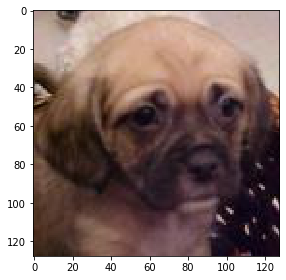

In [9]:
io.imshow(train_1[1,:,:,:])

In [10]:
with h5py.File('cat-dog-dataset.hdf5', 'w') as f:
    d = f.create_dataset('train_0', data=train_0)
    d = f.create_dataset('train_1', data=train_1)
    d = f.create_dataset('test_0', data=test_0)    
    d = f.create_dataset('test_1', data=test_1)    

In [11]:
with h5py.File('cat-dog-dataset-small.hdf5', 'w') as f:
    d = f.create_dataset('train_0', data=train_0[:500])
    d = f.create_dataset('train_1', data=train_1[:500])
    d = f.create_dataset('test_0', data=test_0[:100])    
    d = f.create_dataset('test_1', data=test_1[:100])    